# Gerador de dados sísmicos paralelizado

## Imports e configurações 

In [1]:
import matplotlib.pyplot as plt

from time import time
from joblib import Parallel, delayed
from scipy.signal import convolve2d
from tqdm import tqdm
from utils import * 

import multiprocessing as mp
import numpy as np
import cv2
import random
import os
import shutil
import glob

In [2]:
path_save_retas = './../Code_Pix2Pix/datasets/seismic_e2'
path_save_curves = './../Code_Pix2Pix/datasets/seismic_e4'
delete_existing_samples = True
samples_by_images = 20

## Utils

In [3]:
class ImageUtil:
    @staticmethod
    def show(img, scala=1, color='gray', show_axis=False):
        fig, ax = plt.subplots()
        if not show_axis: ax.axis("off")
        # dpi = float(fig.get_dpi())
        # img_width = int(img.shape[0] / dpi)
        # img_height = int(img.shape[1] / dpi)
        # fig.set_size_inches(scala * img_width, scala * img_height)
        ax.imshow(img, cmap=color)

    
    @staticmethod
    def open(path, color_code=cv2.COLOR_BGR2RGB):
        return cv2.cvtColor(cv2.imread(path), color_code) 

    
    @staticmethod
    def save(img, path, color=None):
        if color == 'seismic':
            vmax = np.max(abs(img))
            plt.imsave(path, img, cmap=color, vmin=-vmax, vmax=vmax)
        else:
            plt.imsave(path, img, cmap=color)
    
    @staticmethod
    def norm(img, negative=True):
        vmin, vmax = img.min(), img.max() 
        img = (img - vmin) / (vmax - vmin)
        if negative:
            img = img * 2 - 1
        return img

In [4]:
class MatplotlibUtil:
    @staticmethod
    def full_frame(width=None, height=None):
        import matplotlib as mpl
        mpl.rcParams['savefig.pad_inches'] = 0
        figsize = None if width is None else (width/100, height/100)
        fig = plt.figure(figsize=figsize, dpi=100)
        ax = plt.axes([0, 0, 1, 1], frameon=False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.autoscale(tight=True)

## PSFs e Ricker

#### Carregando as PSFs

Dados carregados de ./janelas/jequitinhonha.pickle
 - scatter_widths
 - frequencies
 - scatters
Visualizando '' - 6 amostras


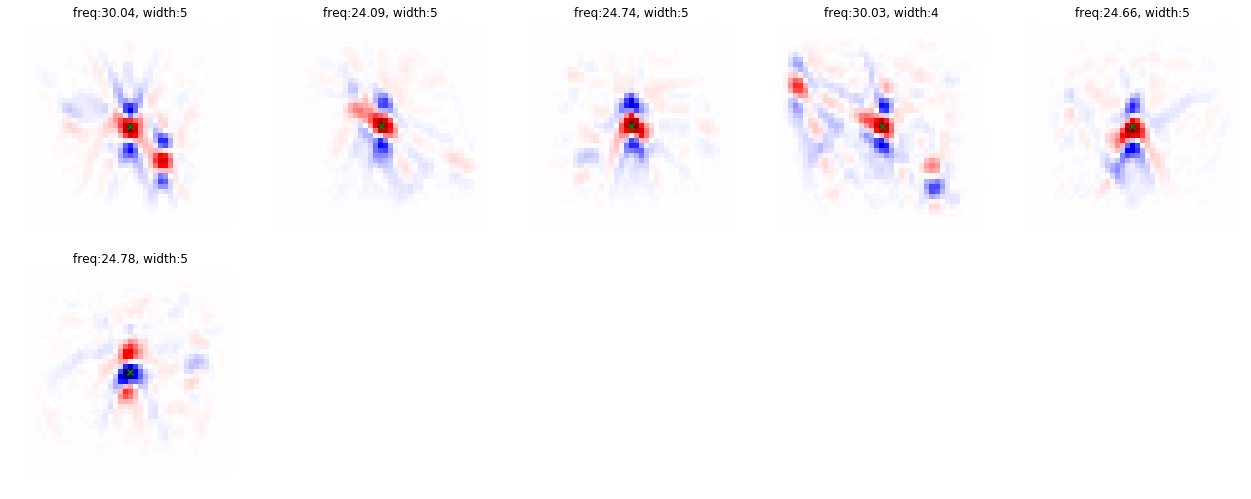

In [5]:
# Arquivo com PSFs
psf_file = './janelas/jequitinhonha.pickle'

data_dic = load_pickle(psf_file)
scatters = data_dic['scatters']
frequencies = data_dic['frequencies']
scatter_widths = data_dic['scatter_widths']

# Visualiza PSFs importados
max_samples = 30
color='seismic'
resize=3.5

# Cria título informativo para cada janela
labels = ['freq:%.2f, width:%d' % (f,w) for f,w in zip(frequencies, scatter_widths)]

if max_samples < scatters.shape[0]:
    num_samples = max_samples
else:
    num_samples = None
    
view_samples(scatters, labels, num_samples=num_samples, resize=resize, color=color)

#### Função que retorna uma das PSFs carregadas

In [6]:
def get_random_psf(return_infos=False):
    # Seleciona um PSF para convolver com o dado de estruturas
    # A ultima PSF não pode ser inserida pois está com a polaridade invertida e a Ricker não.
    psf_index = random.randint(0, len(scatters) - 2)
    
    psf = scatters[psf_index]
    psf_freq = frequencies[psf_index]
    psf_width = scatter_widths[psf_index]

    title = 'freq:%.2f, width:%d' % (psf_freq, psf_width)
    
    if return_infos:
        return psf, psf_freq, psf_width
    else:
        return psf

#### Gerando a Wavelet de Ricker

In [7]:
def get_ricker(psf, psf_freq, psf_width):
    taper_size = 4
    window_size = psf.shape[0]
    dt = 0.004

    # Constrói wavelet
    wavelet = ricker_wavelet(psf_freq, window_size, dt)
    # Constrói wavelet 2D
    wavelet = wavelet.reshape((1,-1)).T
    wavelet_2D = np.empty((window_size, taper_size*2+1), dtype=np.float32)
    wavelet_2D[:,:] = wavelet
    # Suaviza bordas aplicando função de taper
    wavelet_2D = apply_taper(wavelet_2D, taper_size)
    return wavelet_2D 

#### Mostrando um exemplo

Wavelet_2D (41, 9)
Tamanho da imagem (em polegadas): 5.69 x 5.69
Coordenadas:  x - [0.0, 41.0], y - [0.0, 0.2]
Dimensão: (41, 41)



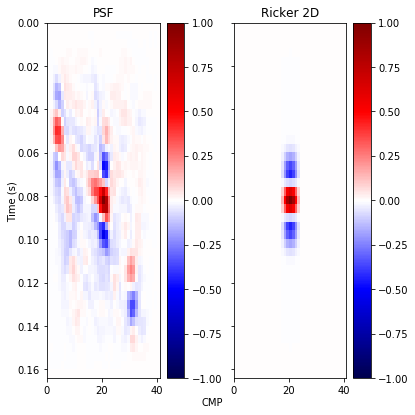

In [8]:
psf, psf_freq, psf_width = get_random_psf(True)
wavelet_2D = get_ricker(psf, psf_freq, psf_width)
print("Wavelet_2D", wavelet_2D.shape)

# Constrói janela para visualização equivalente ao PSF
color='seismic'
resize=10.0

title1='PSF'
title2='Ricker 2D'

taper_size = 4
window_size = psf.shape[0]
dt = 0.004
    
center = int(window_size/2)  
wavelet_window = np.zeros(psf.shape)
wavelet_window[:, center-taper_size:center+(taper_size+1)] += wavelet_2D

multiple_event_viewer(psf, wavelet_window, resize=resize, color1=color, color2=color, dt=dt, title1=title1, title2=title2)

## Gerador do dataset

#### Função para gerar exemplos com retas

In [9]:
def make_sample_retas(i, psf, wavelet_2D, debug=False):
    img_ref = np.zeros((256, 256))
    n_retas = random.randint(10, 15)

    for i in range(n_retas):
        x = random.randint(1, 127)
        y = random.randint(1, 255)
        size = random.randint(127, 255 - x)
        reta = np.ones((1, size))
        img_ref[y, x:x+size] = reta

    noise = 0.1
    img_back = (np.random.random(img_ref.shape) - 0.5) * noise
    noisy_img_ref = img_back + img_ref

    synthetic_psf = convolve2d(noisy_img_ref, psf, mode='same')
    synthetic_ricker2D = convolve2d(noisy_img_ref, wavelet_2D, mode='same')
    
    if debug:
        multiple_event_viewer(noisy_img_ref, synthetic_psf, synthetic_ricker2D,
                          vmin1=0, vmax1=1.0,
                          resize=3, color1='gray', color2='seismic', color3='seismic',
                          title1='Refletores', title2='synthetic_psf', title3='synthetic_ricker2D')

    return synthetic_psf, synthetic_ricker2D

Tamanho da imagem (em polegadas): 10.67 x 10.67
Coordenadas:  x - [0.0, 256.0], y - [0.0, 256.0]
Dimensão: (256, 256)



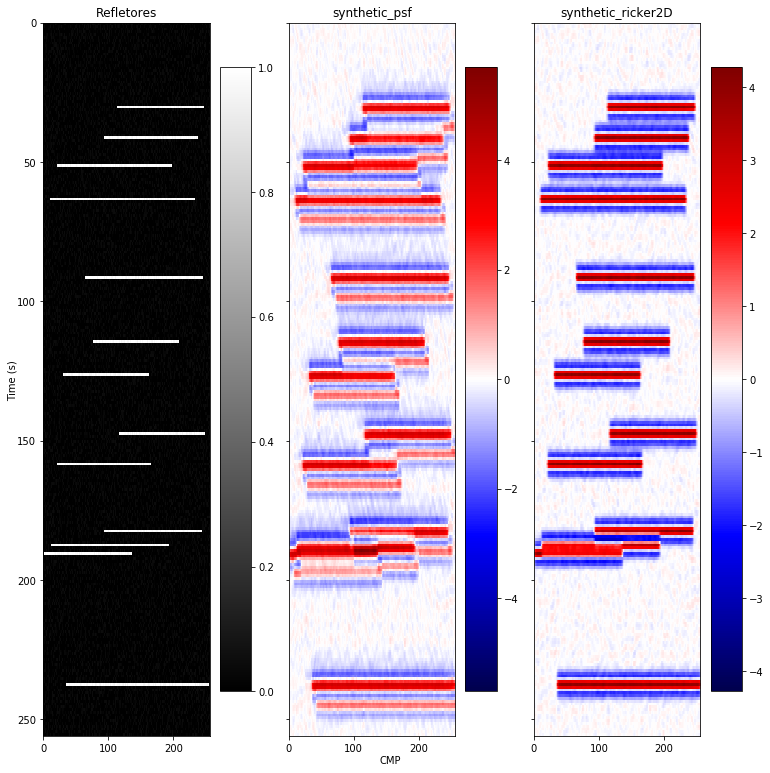

In [10]:
psf, psf_freq, psf_width = get_random_psf(True)
ricker = get_ricker(psf, psf_freq, psf_width)
    
x, y = make_sample_retas(0, psf, ricker, True)

#### Função para gerar exemplos com curva

In [11]:
def plot_to_numpy(fig):
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data


def generate_curves(file_name):
    num_steps = 1000
    num_sections = 2
    theta_end = (2*np.pi)*0.4

    sections = np.empty(num_sections+1, dtype=np.int)
    sections[0] = 0
    sections[-1] = num_steps
    if num_sections > 1:
        sections[1:-1] = np.sort(np.random.choice(np.arange(int(num_steps*0.05),int(num_steps*0.95)),
                                                  (num_sections-1),replace=False))

    count = 0
    phase = np.random.random()*(2*np.pi)
    theta = np.empty(num_steps, dtype=np.float32)
    for begin,end in zip(sections[:-1],sections[1:]):
        theta[begin:end] = 2**count
        count+=1

    theta = np.arange(0,theta_end,theta_end/num_steps) + theta + phase
    chaos = np.cos(theta) + np.sin(theta)
    beta = 0.98
    
    MatplotlibUtil.full_frame(1024, 768)
    plt.ylim(0, 1024)
    
    for offset in range(-150, 1100, 30):
        sigma = np.random.rand() + 1.0
        random_walk = np.empty(num_steps, dtype=np.float32)
        step = (np.random.random() - 0.5) * 8
        for i in range(num_steps):
            random_walk[i] = step
            step = (1-beta)*np.random.normal(loc=chaos[i], scale=sigma) + beta*step
        random_walk -= random_walk.min()

        scale = np.random.rand() * 30 + 30
        reflective_curve = np.round((random_walk*scale) + offset)

        for i in range( random.randint(3, 5) ):
            sinal = [-1, 1][random.randint(0, 1)]
            y = reflective_curve + i * 10 * sinal
            plt.plot(range(num_steps), y, c='black', linewidth=1)     

    plt.savefig(file_name)
    

def runningMean(x, N):
    return convolve2d(x, np.ones((N, N)))


def add_random_fauls(img):
    n_fauls = random.randint(2, 10)
    for i in range(n_fauls):
        x = random.randint(50, 999)
        y = random.randint(50, 512)
        size = random.randint(100, 768 - y)
        img[y:y+size, x:x+10] = np.ones((size, 10))

    return img
    

def make_sample_curves(i, psf, wavelet_2D, debug=True):
    generate_curves(str(i) + ".jpg")
    refletores = ImageUtil.open(str(i) + ".jpg", cv2.COLOR_BGR2GRAY)
    
    refletores = (255 - refletores) / 255
    refletores = runningMean(refletores, 4)
    refletores = add_random_fauls(refletores)
    
    noise = np.random.random(refletores.shape) - 0.5
    refletores = noise + refletores
    
    print("1: ", refletores.min(), refletores.max())
    print("2: ", noise.min(), noise.max())
    
    # Convolução 
    synthetic_psf = convolve2d(refletores, psf, mode='same')
    synthetic_ricker2D = convolve2d(refletores, wavelet_2D, mode='same')
    
    # Normalização 
    synthetic_psf /= np.max(np.abs(synthetic_psf))
    synthetic_ricker2D /= np.max(np.abs(synthetic_ricker2D))
    
    synthetic_psf += noise * 0.02
    synthetic_ricker2D += noise * 0.01
    
    if debug:
        print("Original Size: ", synthetic_psf.shape)
        print("Refletores: ", refletores.min(), refletores.max())
        print("PSF:", psf.min(), psf.max())
        print("Ricker:", wavelet_2D.min(), wavelet_2D.max())
        
        multiple_event_viewer(refletores, synthetic_psf, synthetic_ricker2D,
                              vmin1=0, vmax1=1.0,
                              resize=1, color1='gray', color2='seismic', color3='seismic',
                              title1='Refletores', title2='synthetic_psf', title3='synthetic_ricker2D')
    
        
        ImageUtil.save(refletores, 'r.jpg')
        ImageUtil.save(synthetic_psf, 'x.jpg', color='seismic')
        ImageUtil.save(synthetic_ricker2D, 'y.jpg', color='seismic')
    
    psfs, rickers = [], []
    for i in range(256, synthetic_psf.shape[0], 256):
        for j in range(256, synthetic_psf.shape[1], 256):
            psfs.append(synthetic_psf[i-256:i, j-256:j])
            rickers.append(synthetic_ricker2D[i-256:i, j-256:j])
    
    for i in range(8):
        x = random.randint(1, 768)
        y = random.randint(1, 512)
        psfs.append(synthetic_psf[y:y+256, x:x+256])
        rickers.append(synthetic_ricker2D[y:y+256, x:x+256])
     
    if debug:
        print("Lens:", len(rickers), len(psfs))
    
    return psfs, rickers

1:  -0.4999926879927796 16.117687401553514
2:  -0.49999975128189633 0.49999984313877344
Original Size:  (771, 1027)
Refletores:  -0.4999926879927796 16.117687401553514
PSF: -0.52009183 1.0
Ricker: -0.44596404 1.0
Tamanho da imagem (em polegadas): 14.26 x 10.71
Coordenadas:  x - [0.0, 1027.0], y - [0.0, 771.0]
Dimensão: (771, 1027)



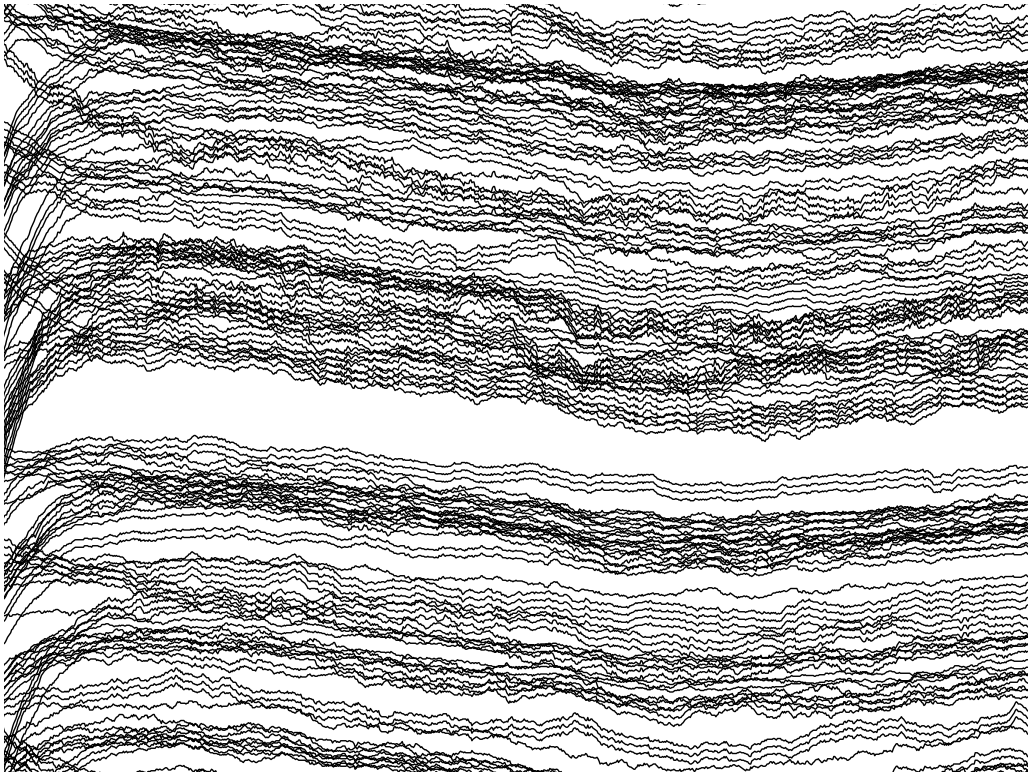

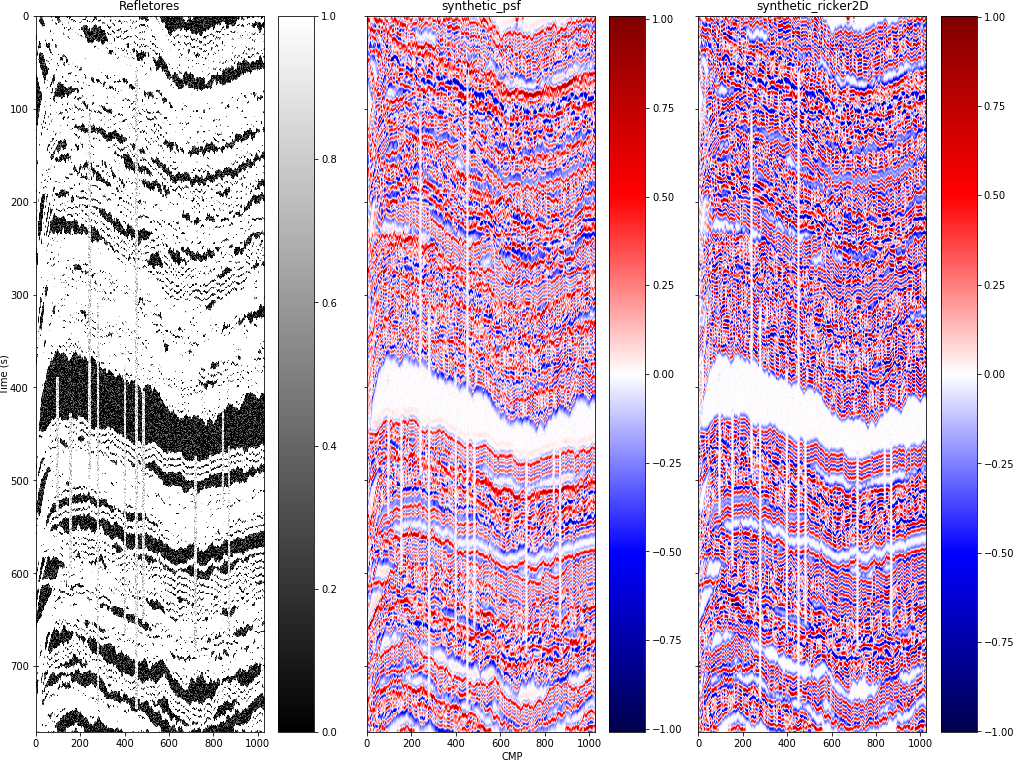

Lens: 20 20
Time:  8.159950971603394


In [12]:
t = time()

psf, psf_freq, psf_width = get_random_psf(True)
ricker = get_ricker(psf, psf_freq, psf_width)

x, y = make_sample_curves(0, psf, ricker, True)
print("Time: ", time() - t)

In [13]:
def process_sample(make_sample_func, path, index):
    psf, psf_freq, psf_width = get_random_psf(True)
    ricker = get_ricker(psf, psf_freq, psf_width)
    xs, ys = make_sample_func(index, psf, ricker)
    for i, (x, y) in enumerate(zip(xs, ys)):
        img = np.append(x, y, axis=1)
        ImageUtil.save(img, path + "/" + str(i + index) + ".jpg", color='gray')
    
def create_dataset(n_samples, tipos_refletores, path):
    start_time = time()
    
    if tipos_refletores == 'retas': msf = make_sample_retas 
    else: msf = make_sample_curves 
        
    if not os.path.exists(path): 
        os.mkdir(path)
    elif delete_existing_samples:
        shutil.rmtree(path, ignore_errors=True)
        os.mkdir(path)    
    
    folders = [ ("train", n_samples), 
                ("val", int(n_samples * 0.2)), 
                ("test", int(n_samples * 0.2)) ]
    
    nc = mp.cpu_count()
    print("Cpu count: ", nc)
    
    for j in range(len(folders)):
        
        print("Generating: ", folders[j][0])
        path_temp = path + "/" + folders[j][0]
        start = 0
        !rm -rf *.jpg
        
        if not os.path.exists(path_temp):
            os.mkdir(path_temp)
        else:
            files = glob.glob(path_temp + "/*.jpg")
            files.sort(key=lambda x: int(x.split('/')[-1][:-4]))
            if len(files) > 0: start = int(files[-1].split('/')[-1][:-4]) + 1
        Parallel(n_jobs=nc)(delayed(process_sample) (msf, path_temp, i) for i in tqdm(range(start, folders[j][1], samples_by_images)))
    
    for folder in folders:
        path_temp = path + "/" + folder[0]
        print("Total de imagens de {0}: {1}".format(folder[1], len(glob.glob(path_temp + "/*.jpg"))))
        
    print("Time: ", time() - start_time)

In [ ]:
create_dataset(10000, "curves", path_save_curves)
# create_dataset(100, "curves", ".")
# create_dataset(1, 'retas', path_save_retas)

Cpu count:  8
Generating:  train


100%|██████████| 500/500 [12:25<00:00,  1.62s/it]


Generating:  val


 44%|████▍     | 44/100 [00:48<02:32,  2.72s/it]/home/ubuntu/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
100%|██████████| 100/100 [02:13<00:00,  1.93s/it]


Generating:  test


 47%|████▋     | 47/100 [00:48<00:26,  1.97it/s]